<a href="https://colab.research.google.com/github/CyberIngeniero/Proyecto_Clustering_HDI/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\color{forestgreen}{\underline{\text{Proyecto Nuevos Clusters para Vehículos}}}$

# Librerias

In [ ]:
#pip install pydotplus

In [65]:
# Librerias
import os
import shutil
import sys

from google.colab import files    #files.upload()
from google.colab import drive    #drive.mount('/gdrive')

import pandas as pd

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.impute import SimpleImputer

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials #Bayesiano

import pydotplus
from sklearn.tree import export_graphviz

import missingno as msno

from IPython.display import display, Markdown, Image

import warnings
warnings.filterwarnings("ignore")

In [114]:
def df_norm(df):
    """
    :param df: df con variables a agrupar
    """

    cols = ['edad_bins', 'antiguedad_bins', 'sisgen_bins']
    enc = LabelEncoder()

    # Agrupacion de edad del asegurado
    df['edad_bins'] = pd.cut(x = df['edad'], 
                            bins = [-3, -2, -1, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100], 
                            labels = ['Extranjero', 'Empresa', '0 - 18', '19 - 25', '26 - 30', 
                                      '31 - 35', '36 - 40', '41 - 45', '46 - 50', '51 - 55', 
                                      '56 - 60', '61 - 65', '66 - 70', 'Mayor a 70'])

    # Agrupacion de Antiguedad de vehiculo
    df['antiguedad_bins'] = pd.cut(x = df['antiguedad_veh'], 
                                   bins = [-1, 0, 2, 4 ,8, 20],
                                   labels = ['0', '1 - 2', '3 - 4', '5 - 8', '9+'])

    # Agrupacion de sisgen
    df['sisgen_bins'] = pd.cut(x = df['sisgen_usar'], 
                               bins = [0, 0.85 , 0.91, 0.95 , 0.992, 
                                       1.08, 1.1  , 1.3, 1.5],
                               labels = ['S0.85', 'S0.87 - 0.91', 'S0.91 - 0.95', 
                                         'S0.95 - 0.97','S0.993 - 1.08', 'S1.1', 
                                         'S1.133 - 1.3', 'S1.333 - 1.5'])
    
    
    df.drop(columns = ['sisgen_usar', 'antiguedad_veh', 'edad'], axis = 1, inplace = True)

    for col in cols:
        colname = col + '_code'
        df[colname] = enc.fit_transform(df[col])
        df.drop(columns = [col], axis = 1, inplace = True)


# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    """
    :param
    :param
    :param
    :param
    :param
    """
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    """
    :param
    :param
    :param
    :param
    :param
    """
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()


def confusion_to_df(mc):
    """
    :param mc: Matriz de Confusion
    :return: Matriz de Confusion como df
    """
    mc = mc.T
    df_mc = pd.concat([pd.Series(mc[0]), pd.Series(mc[1])], axis=1)
    df_mc.columns = ['Verdadero', 'Falso']
    df_mc.index = ['Verdadero', 'Falso']
    return df_mc


def metrics_report(model, X_train, y_train, X_test, y_test):
    # Fit Model
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]


    print('----------------------------------------------------------------------------')
    print('Metrics Report Model ' + model.__class__.__name__ + ' -- Training Dataset')
    print('---------------------------------------------------------------------------- \n')

    # metrics
    print("Precision: %f "%precision_score(y_train, y_train_pred))
    print("Recall: %f "%recall_score(y_train, y_train_pred))
    print("F1: %f"% f1_score(y_train, y_train_pred)) 
    print("AUC: ", roc_auc_score(y_train, y_train_pred))

    #matriz de confusion
    print("\n MATRIZ DE CONFUSION")
    display(confusion_to_df(confusion_matrix(y_train, y_train_pred)))

    # Metrics Resume
    print("\n MÉTRICAS DEL MODELO")
    display(pd.DataFrame(classification_report(y_train, y_train_pred, output_dict = True)))

    # grafica curva roc
    fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='tomato')
    plt.plot(fpr, tpr, marker='.', lw=2)
    plt.title("ROC curve model " + model.__class__.__name__)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show();

    # Trade-off precision_recall
    print("\n TRADE-OFF PRECISION RECALL - TRAINING SET")
    prec, rec, tre = precision_recall_curve(y_train, y_train_proba, )
    plot_prec_recall_vs_tresh(prec, rec, tre)
    plt.show();

    print('\n \n ----------------------------------------------------------------------------')
    print('Metrics Report Model ' + model.__class__.__name__ + ' -- Testing Dataset')
    print('---------------------------------------------------------------------------- \n')

    # metrics
    print("Precision: %f "%precision_score(y_test, y_test_pred))
    print("Recall: %f "%recall_score(y_test, y_test_pred))
    print("F1: %f"% f1_score(y_test, y_test_pred))
    print("AUC: ", roc_auc_score(y_test, y_test_pred))

    # matriz de confusion
    print("\n MATRIZ DE CONFUSION")
    display(confusion_to_df(confusion_matrix(y_test, y_test_pred)))

    # Metrics Resume
    print("\n MÉTRICAS DEL MODELO")
    display(pd.DataFrame(classification_report(y_test, y_test_pred, output_dict = True)))

    # grafica curva roc
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='tomato')
    plt.plot(fpr, tpr, marker='.', lw=2)
    plt.title("ROC curve model " + model.__class__.__name__)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show();

    # Trade-off precision_recall
    print("\n TRADE-OFF PRECISION RECALL - TESTING SET")
    prec, rec, tre = precision_recall_curve(y_test, y_test_proba, )
    plot_prec_recall_vs_tresh(prec, rec, tre)
    plt.show();


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, 
                               feature_names=feature_names, 
                               filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)


def acc_model(params):
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()


def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}    


def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()     


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])       

# Carga y Lectura de Registros

In [4]:
# Se crea directorio de trabajo
path = "/tmp/data_clusters"
os.mkdir(path)

In [5]:
# Montando Drive
#4/4gEf6NBxl3r6aZLslb7tO0RAAjKgz0WuuOwRjQHrwSMztmGxS_7U4Uk
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
# Copia del archivo a directorio local
!cp  /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/Clustering_22_09_2020.csv /tmp/data_clusters

In [7]:
# Moviendo datos a entorno de trabajo
os.rename("/tmp/data_clusters/Clustering_22_09_2020.csv", "/tmp/data_clusters/Base_Clusters_MM.csv")

In [8]:
# Cambiando a directorio de trabajo
os.chdir(path)
print(os.getcwd())

/tmp/data_clusters


In [9]:
df = pd.read_csv("Base_Clusters_MM.csv", delimiter = ';', decimal=",")
df.columns = df.columns.str.lower()
df = df.rename(columns = {'sum([cantidad convertida final])':'cantidad_polizas',
                          'edad_final':'edad'})
df = df.drop(['edad_asegurado'], axis = 1) #version de edad asegurado en el cual se tiene junto extranjero a los 35 años

In [10]:
display(df.head())

rut_num  antiguedad_veh  ...  rc_ltv_precot  tasa_conversion
0  24855954.0               0  ...         0.9091          100,00%
1  16173686.0               0  ...         0.9421          100,00%
2  14183913.0               0  ...         0.8486          100,00%
3  23418340.0               0  ...         0.9338          100,00%
4  18885743.0               0  ...         1.1170          100,00%

[5 rows x 20 columns]

# Data Treatment

In [11]:
# Información de la data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983239 entries, 0 to 983238
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   rut_num                          983207 non-null  float64
 1   antiguedad_veh                   983239 non-null  int64  
 2   dia_precot                       983239 non-null  int64  
 3   prima_neta_deducible_anualizada  983233 non-null  float64
 4   sisgen_usar                      983239 non-null  float64
 5   mod_tasacion_fiscal              978799 non-null  float64
 6   precot_veh_modelo_id             983239 non-null  int64  
 7   canal_producto                   983239 non-null  object 
 8   precot_veh_tipo_id               983239 non-null  int64  
 9   precot_veh_tipo                  983239 non-null  object 
 10  precot_veh_uso                   983239 non-null  object 
 11  precot_veh_uso_id                983239 non-null  int64  
 12  nu

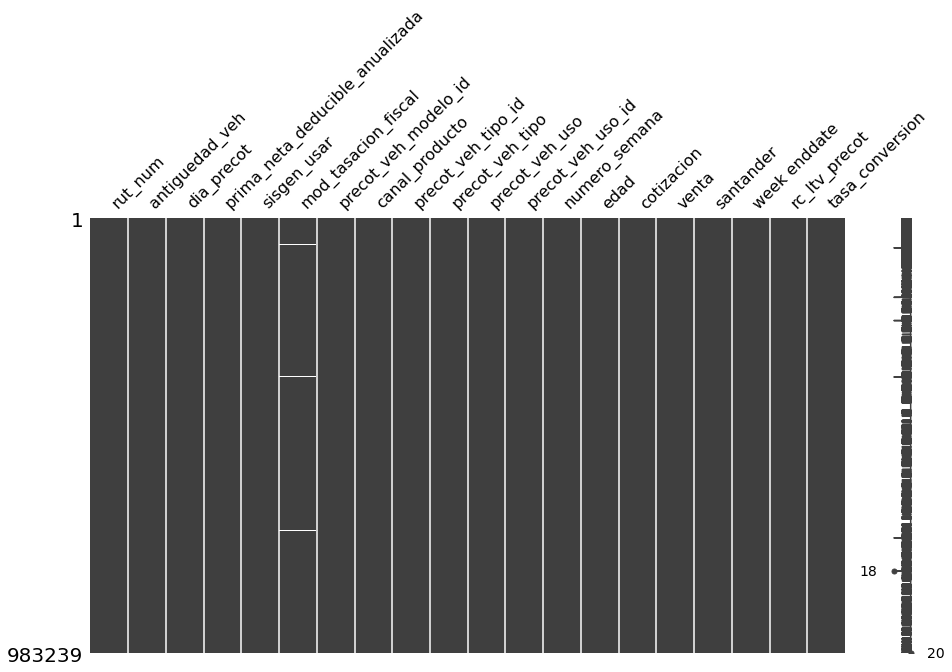

In [12]:
# Analisis de Datos Perdidos
msno.matrix(df, figsize=(15,8));

In [13]:
# Conteo de Registros NUlos
print('Valores Nulos por Columna \n')
df.isnull().sum(axis = 0)

Valores Nulos por Columna 



rut_num                              32
antiguedad_veh                        0
dia_precot                            0
prima_neta_deducible_anualizada       6
sisgen_usar                           0
mod_tasacion_fiscal                4440
precot_veh_modelo_id                  0
canal_producto                        0
precot_veh_tipo_id                    0
precot_veh_tipo                       0
precot_veh_uso                        0
precot_veh_uso_id                     0
numero_semana                         0
edad                                  0
cotizacion                            0
venta                                 0
santander                             0
week enddate                          0
rc_ltv_precot                         7
tasa_conversion                       0
dtype: int64

__COMENTARIOS__
 - Para favorecer el análsis, los registros nulos será imputados por la media de cada columna.

In [14]:
# Ajuste de Variables

# Ajuste de varibale rut_num
#df.dropna(axis = 0, subset=['rut_num'], inplace = True) #registros con rut vacio
df['rut_num'] = df['rut_num'].astype('object')

# Ajuste de varibale prima_neta_deducible_anualizada
df['prima_neta_deducible_anualizada'].fillna(round(df['prima_neta_deducible_anualizada'].mean(), 2), inplace = True)

# Ajuste de varibale rc_ltv_precot
df['rc_ltv_precot'].fillna(round(df['rc_ltv_precot'].mean(), 2), inplace = True)

# Ajuste de varibale precot_veh_modelo_id
df['precot_veh_modelo_id'] = df['precot_veh_modelo_id'].astype('object')

# Ajuste de varibale santander
df['santander'] = df['santander'].astype('int32')
df['santander'] = df['santander'].astype('object')

# Ajuste de varibale numero_semana
df['numero_semana'] = df['numero_semana'].fillna(value = '0').astype('int32')

# Ajuste de varibale tasacion fiscal
df['mod_tasacion_fiscal'] = df['mod_tasacion_fiscal'].fillna(value = '11').astype('int32')

# Ajuste de Variable Edad
df['edad'].replace({'Empresa' : '-1', 
                    'Extranjero' : '-2'}, 
                   inplace = True)

df['edad'] = df['edad'].astype('int32')

df['edad'].fillna(value = int(df['edad'].mean()),
                  inplace = True)               


# Ajuste de Variable antiguedad_veh
df['antiguedad_veh'] = df['antiguedad_veh'].astype('int32')

# Ajuste de varibale precot_veh_modelo_id
df['precot_veh_uso'].replace({'Particular (Vehículos de uso personal y/o familiar destinado al transporte sin fines de lucro)' : 'Particular', 
                              'Otros usos comerciales distintos de transporte de pasajero y/o carga' : 'Otros Usos', 
                              'Transporte Pasajeros' : 'Transporte',
                              'Taxi Básico' : 'Taxi',
                              'Vehículo de Reparto' : 'Reparto'}, inplace=True)

# Ajuste de varibale santander
df['venta'] = df['venta'].astype('object')

In [15]:
df.describe()

antiguedad_veh     dia_precot  ...     cotizacion  rc_ltv_precot
count   983239.000000  983239.000000  ...  983239.000000  983239.000000
mean         2.911086      15.842948  ...       1.006942       0.875026
std          3.331797       8.657400  ...       0.084584       0.177648
min          0.000000       1.000000  ...       1.000000     -73.400000
25%          0.000000       9.000000  ...       1.000000       0.805600
50%          2.000000      16.000000  ...       1.000000       0.888600
75%          5.000000      23.000000  ...       1.000000       0.946100
max         19.000000      31.000000  ...       7.000000      78.900000

[8 rows x 11 columns]

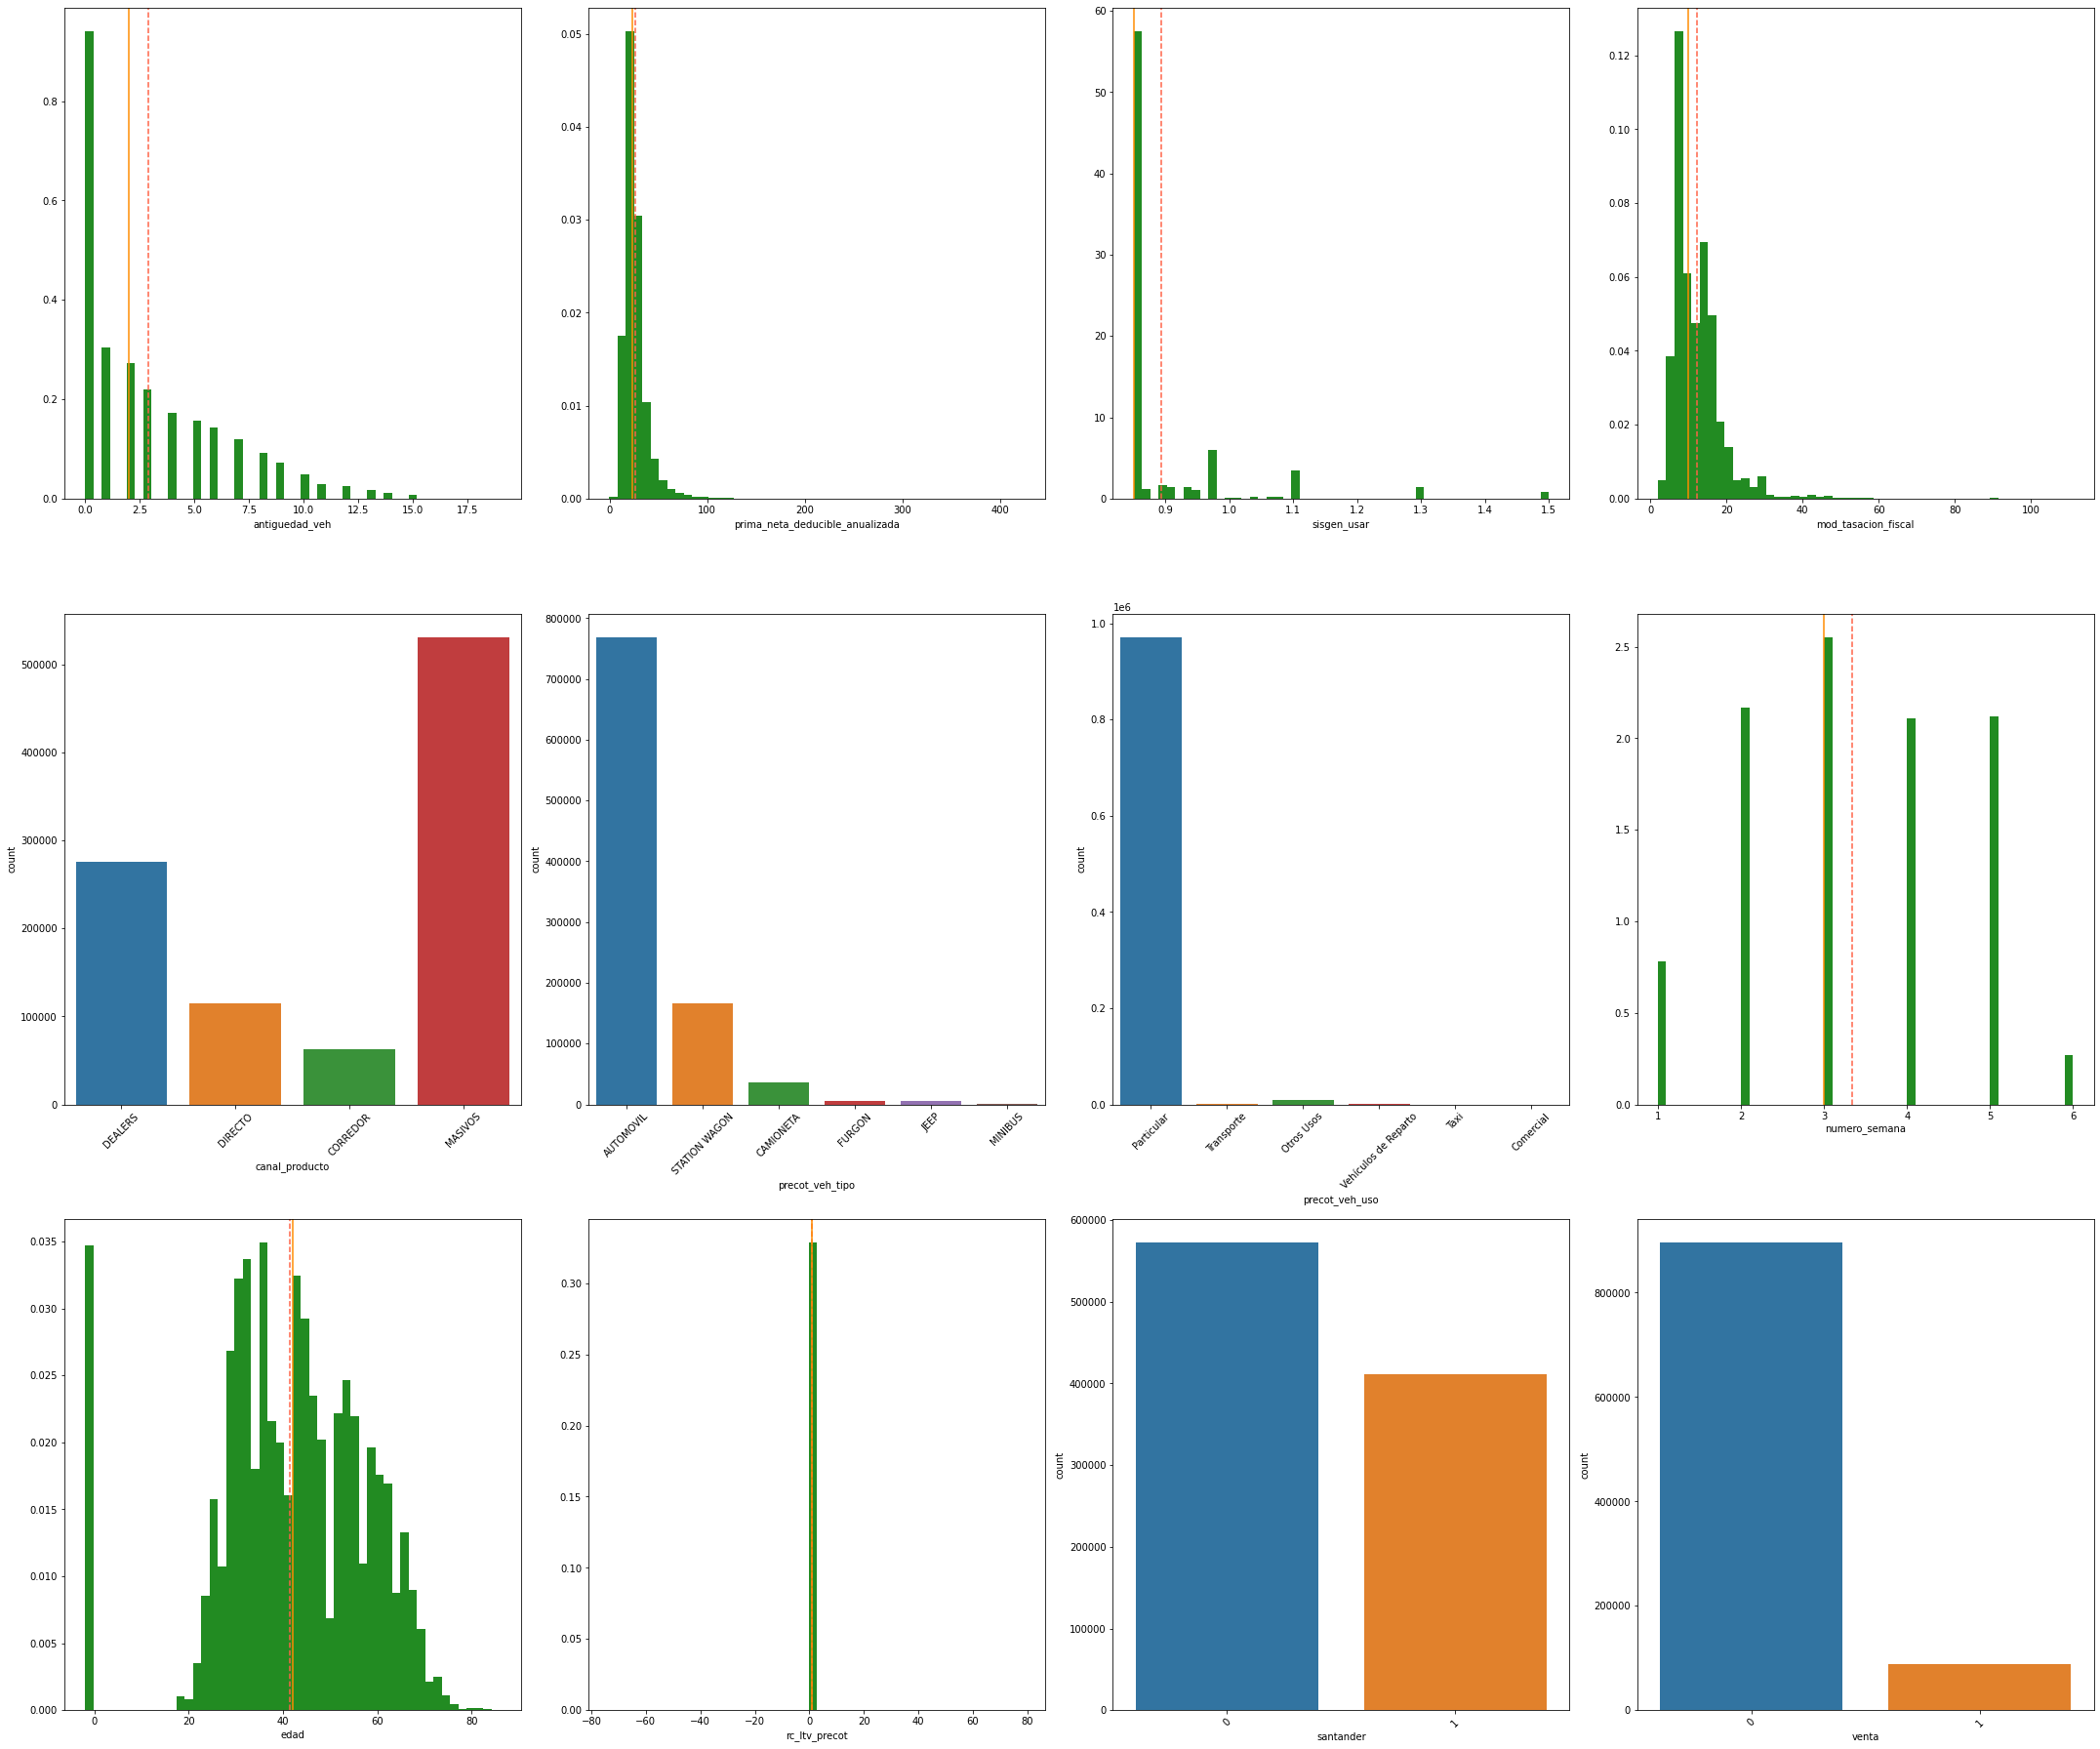

In [16]:
# Analisis Univariado
variables = ['antiguedad_veh', 'prima_neta_deducible_anualizada', 'sisgen_usar',
             'mod_tasacion_fiscal', 'canal_producto', 'precot_veh_tipo', 
             'precot_veh_uso', 'numero_semana', 'edad', 'rc_ltv_precot', 'santander', 'venta']

i = 0
m = 0

fig, axs = plt.subplots(3, 4, constrained_layout=True, figsize = (30,25))

for var in variables:
    if df[var].dtype == 'O':
        sns.countplot(var, data=df, ax = axs[m,i])
        plt.setp(axs[m,i].xaxis.get_majorticklabels(), rotation=45)

        i += 1

        if i % 4 == 0:
            m += 1
            i = 0
    else:
        axs[m,i].hist(df[var], density=True, color="forestgreen", bins=50)
        axs[m,i].axvline(df[var].mean(), color='tomato', linestyle='--', label='mean')
        axs[m,i].axvline(df[var].median(), color='darkorange', linestyle='-', label='median')
        #axs[m,i].set_xlim([df[var].min() - 1, df[var].max() + 1])
        #axs[m,i-1].set_title(var)
        axs[m,i].set_xlabel(var);
        plt.xticks(rotation=45)

        i += 1

        if i % 4 == 0:
            m += 1
            i = 0

#axs[2, 3].remove()             

fig.tight_layout()
plt.show();  

__Comentarios__
- Se sugiere realizar agrupaciones en las variables `edad` y `antiguedad_veh`.
- La variable objetivo `venta` se muestra desbalanceada, lo que será tratado más adelante.

## Generando Agrupaciones

In [17]:

# Agrupacion de edad del asegurado
df['edad_bins'] = pd.cut(x = df['edad'], 
                        bins = [-3, -2, -1, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100], 
                        labels = ['Extranjero', 'Empresa', '0 - 18', '19 - 25', '26 - 30', 
                                '31 - 35', '36 - 40', '41 - 45', '46 - 50', '51 - 55', 
                                '56 - 60', '61 - 65', '66 - 70', 'Mayor a 70'])

# Agrupacion de Antiguedad de vehiculo
df['antiguedad_bins'] = pd.cut(x = df['antiguedad_veh'], 
                            bins = [-1, 0, 2, 4 ,8, 20],
                            labels = ['0', '1 - 2', '3 - 4', '5 - 8', '9+'])

# Agrupacion de sisgen
df['sisgen_bins'] = pd.cut(x = df['sisgen_usar'], 
                        bins = [0, 0.85 , 0.91, 0.95 , 0.992, 1.08, 1.1  , 1.3, 1.5],
                        labels = ['S0.85', 'S0.87 - 0.91', 'S0.91 - 0.95', 'S0.95 - 0.97','S0.993 - 1.08', 'S1.1', 'S1.133 - 1.3', 'S1.333 - 1.5'])                                    

__Comentario__
- Para agrupar las variables `edad`, `antiguedad_veh` Y  `sisgen_usar` se utilizo como criterio las agrupaciones existentes hoy en día en el modelo de vehiculos vigente.

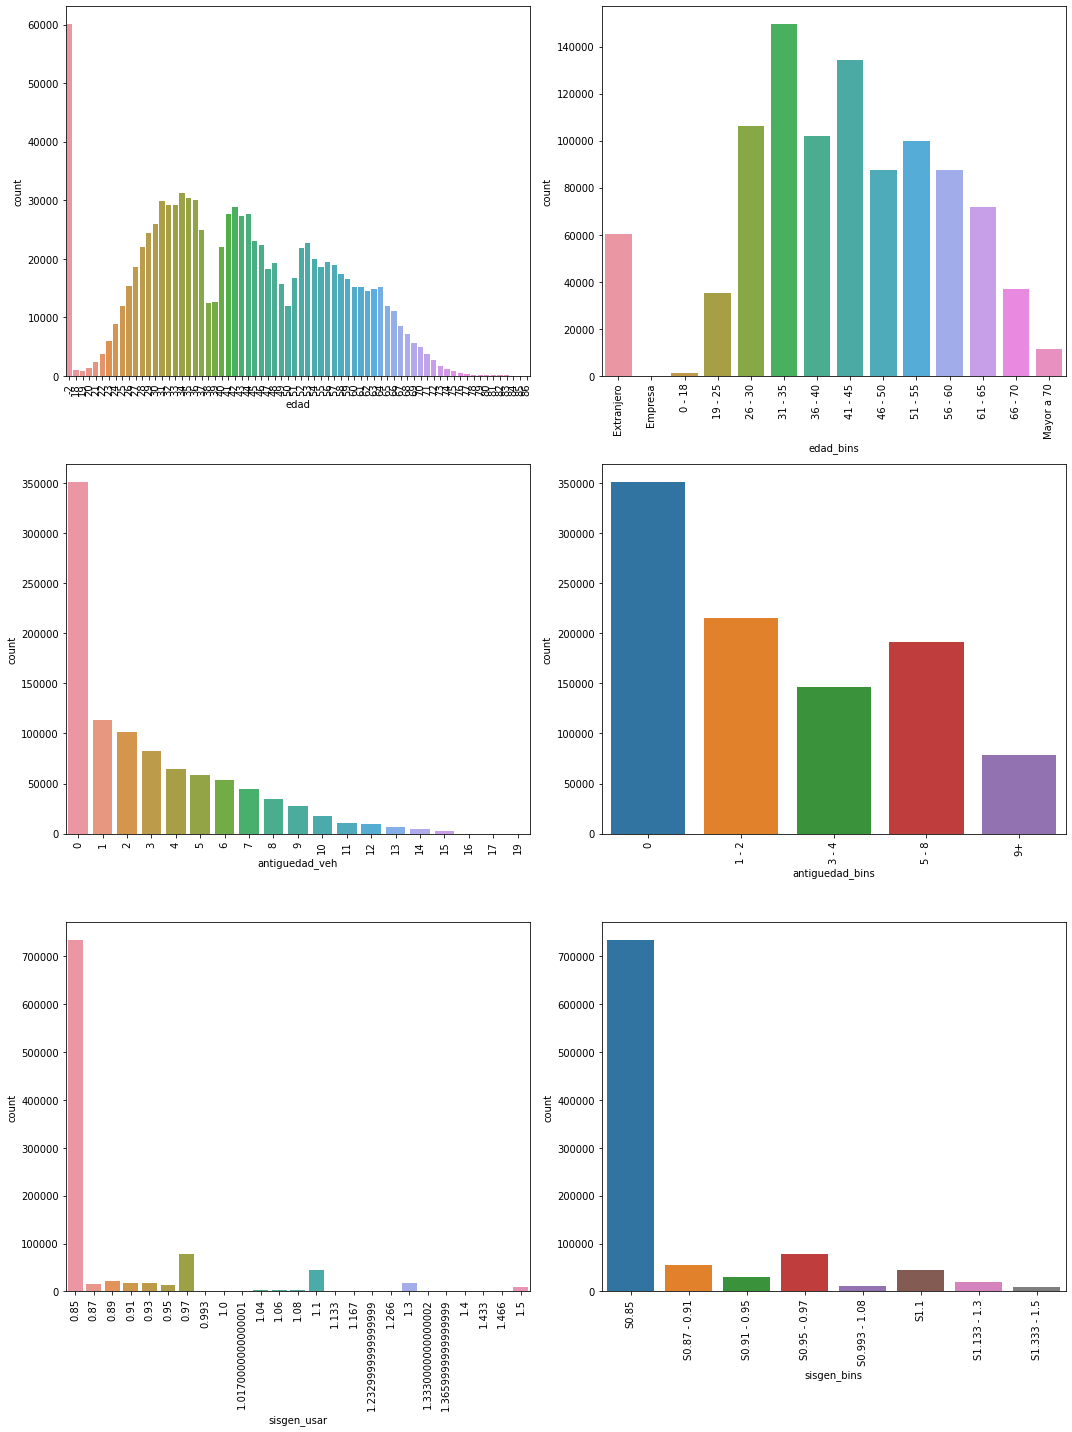

In [18]:
variables = ['edad', 'edad_bins', 'antiguedad_veh', 'antiguedad_bins', 'sisgen_usar', 'sisgen_bins']

i = 0
m = 0

fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize = (15,20))

for var in variables:
    sns.countplot(var, data=df, ax = axs[m,i])
    plt.setp(axs[m,i].xaxis.get_majorticklabels(), rotation=90)

    i += 1

    if i % 2 == 0:
        m += 1
        i = 0        

fig.tight_layout()
plt.show();  

## Análisis Variable Objetivo: `venta`

In [19]:
# Porcentaje de 0 y 1 respectivamente
df['venta'].value_counts()

0    895578
1     87661
Name: venta, dtype: int64

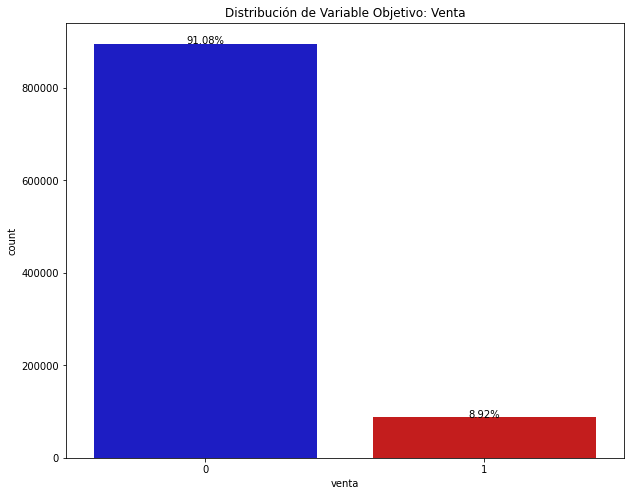

In [20]:
# Graficamente
total = float(len(df))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = df, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Objetivo: Venta')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Variable Objetivo Filtrando Santander

In [21]:
# se filtran registros que no corresponden a santander
df_filter = df[df['santander'] == 0]

print('data original: ', df.shape)
print('data sin santander: ', df_filter.shape)

data original:  (983239, 23)
data sin santander:  (572204, 23)


In [22]:
# Porcentaje de 0 y 1 respectivamente
df_filter['venta'].value_counts()

0    488935
1     83269
Name: venta, dtype: int64

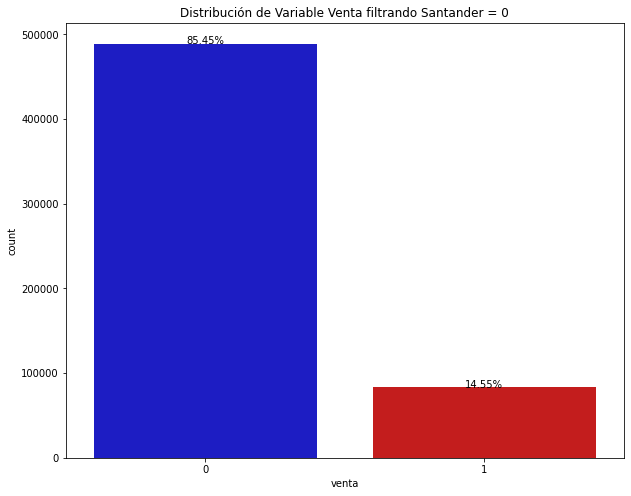

In [23]:
# Graficamente
total = float(len(df_filter))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = df_filter, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Venta filtrando Santander = 0')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

# Análisis de Outliers

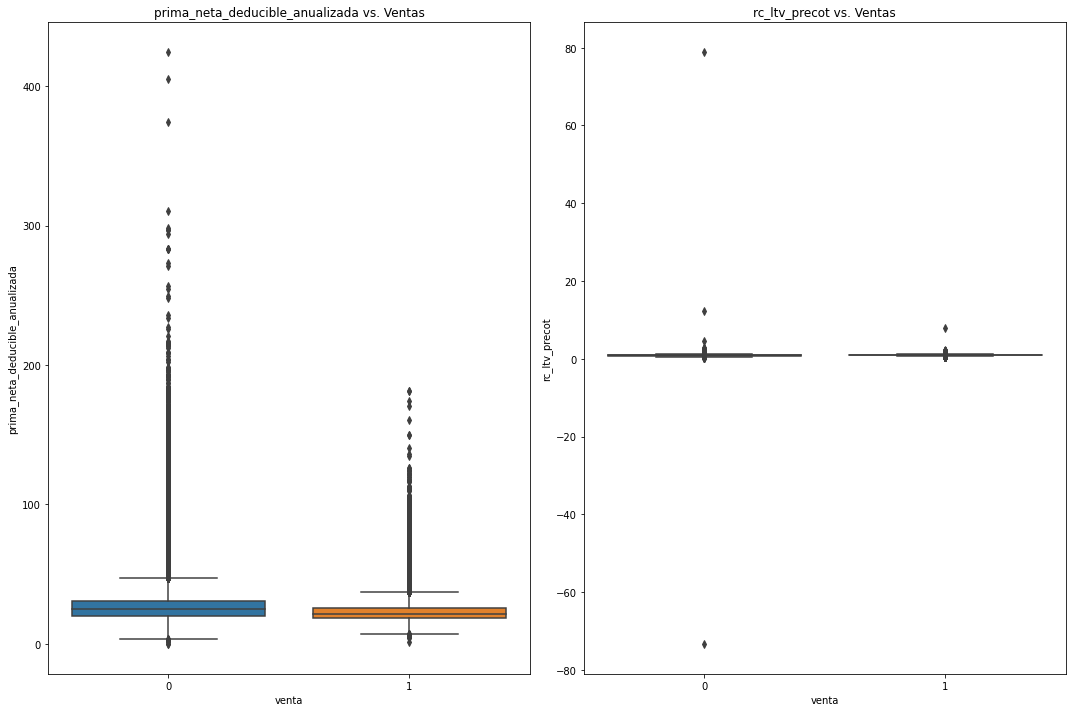

In [24]:
# Dispersion de variables y detección de Outliers: Boxplot
variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot']

i = 0

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize = (15,10))

for var in variables:
    sns.boxplot(x = 'venta', 
                y = var, 
                data = df_filter,
                ax = axs[i])
    axs[i].set_title(var + ' vs. Ventas')

    i += 1     

fig.tight_layout()
plt.show();

## Tratamiento de Outliers

In [25]:
# # Deteccion y Eliminación de Outliers por Zscore
# variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot', 'mod_tasacion_fiscal']

# threshold = 3  #3 desviaciones standar

# for var in variables:
#     z = np.abs(stats.zscore(df_filter[var]))
#     outliers_index = np.where(z > threshold)
#     df_filter = df_filter.loc[~df_filter.index.isin(outliers_index[0])]

In [25]:
# Deteccion y Eliminación de Outliers por IQR
variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot']

for var in variables:
    Q1 = df_filter[var].quantile(0.25)
    Q3 = df_filter[var].quantile(0.75)
    IQR = Q3 - Q1
    outlier_indices = df_filter[(df_filter[var] < Q1 - 1.5 * IQR) | (df_filter[var] > Q3 + 1.5 * IQR)].index
    df_filter = df_filter.loc[~df_filter.index.isin(outlier_indices)]

print('data sin santander ni outliers: ', df_filter.shape)    

data sin santander ni outliers:  (528770, 23)


## Inspección de Variables tratadas

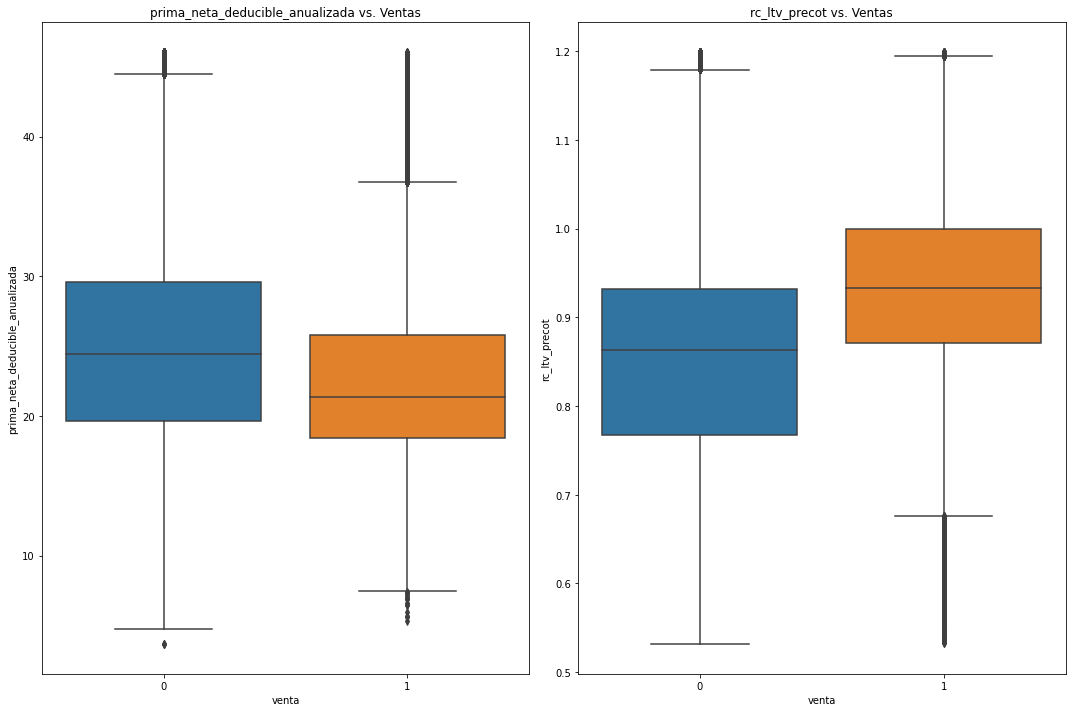

In [26]:
# Dispersion de variables sin outliers
variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot']

i = 0

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize = (15,10))

for var in variables:
    sns.boxplot(x = 'venta', 
                y = var, 
                data = df_filter,
                ax = axs[i])
    axs[i].set_title(var + ' vs. Ventas')

    i += 1     

fig.tight_layout()
plt.show();

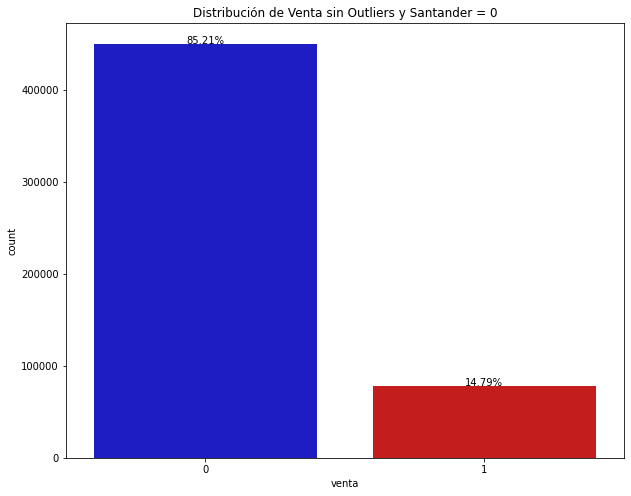

In [27]:
# Graficamente
total = float(len(df_filter))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = df_filter, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Venta sin Outliers y Santander = 0')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

# Modelacion

## Filtrando Variables que formaran parte de la modelación.

In [28]:
# Borrando variables que no se usaran
df_filter.drop(columns = ['rut_num', 'antiguedad_veh', 'sisgen_usar',
                          'precot_veh_modelo_id', 'precot_veh_tipo', 
                          'precot_veh_uso', 'numero_semana', 'edad', 
                          'cotizacion', 'santander', 'week enddate', 
                          'tasa_conversion', 'edad'],
               inplace = True)

## Codificando variables categoricas

In [29]:
# Codificando Canal de Venta
canal_dict = {'DEALERS' : 1,
              'DIRECTO' : 2,
              'MASIVOS' : 3,
              'CORREDOR' : 4}

df_filter['canal_code'] = df_filter.canal_producto.map(canal_dict)
df_filter.drop(columns = ['canal_producto'], axis = 1, inplace = True)

In [30]:
cols = ['edad_bins', 'antiguedad_bins', 'sisgen_bins']

enc = LabelEncoder()

for col in cols:
        colname = col + '_code'
        df_filter[colname] = enc.fit_transform(df_filter[col])
        df_filter.drop(columns = [col], axis = 1, inplace = True)

In [31]:
# Vista previa de los registros a modelar
display(df_filter)

dia_precot  ...  sisgen_bins_code
0               25  ...                 0
1               25  ...                 0
3                2  ...                 0
4               24  ...                 0
5               21  ...                 0
...            ...  ...               ...
983230           8  ...                 0
983232          29  ...                 0
983233          30  ...                 0
983234          27  ...                 7
983235           7  ...                 0

[528770 rows x 11 columns]

## Data Split

In [32]:
# Genera data de train y test
data_train, data_test = train_test_split(df_filter, test_size=.3, stratify = df_filter.iloc[:,5], random_state = 0)
print('data_train: ', data_train.shape)
print('data_test: ', data_test.shape)

data_train:  (370139, 11)
data_test:  (158631, 11)


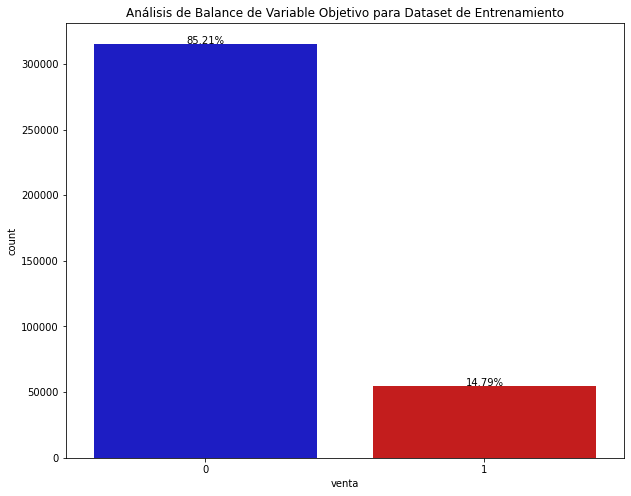

In [33]:
# Graficamente
total = float(len(data_train))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = data_train, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Análisis de Balance de Variable Objetivo para Dataset de Entrenamiento')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Control del Desbalance: Remuestreo

In [34]:
# Subsampling
data = data_train.sample(frac = 1) # Remuestro

target_1 = data.loc[data['venta'] == 1]
target_0 = data.loc[data['venta'] == 0][:len(target_1)]

sub_sample = pd.concat([target_1,target_0])
sub_sample = sub_sample.sample(frac = 1, random_state = 0).reset_index(drop = True)


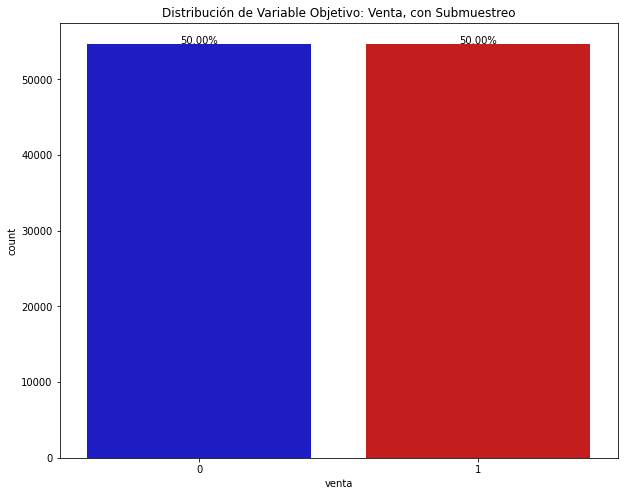

In [35]:
# Graficamente
total = float(len(sub_sample))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = sub_sample, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Objetivo: Venta, con Submuestreo')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Separando Vector Objetivo y Matriz de Diseño

In [36]:
# Separando X e y para train & test
X_train = sub_sample.drop(columns = ['venta'])
y_train = sub_sample['venta'].astype(int)

X_test = data_test.drop(columns = ['venta'])
y_test = data_test['venta'].astype(int)

## Optimización de Hiperparametros

In [37]:
#Fit Decision Tree Classifier
tree_params = {'criterion':['gini','entropy'],
               'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50]}

tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 16626),
                          param_grid = tree_params,
                          cv = 5,
                          n_jobs = -1).fit(X_train, y_train)

print('Mejor score: ', tree_grid.best_score_)
print('Mejores Parametros: ', tree_grid.best_params_)

Mejor score:  0.7596108167367074
Mejores Parametros:  {'criterion': 'entropy', 'max_depth': 8}


## Grafico de Desempeño

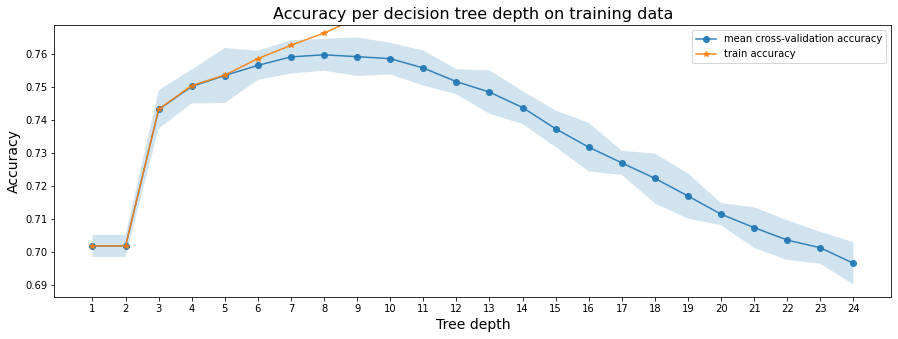

In [38]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')                             

In [39]:
# Best params
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]

print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-8 tree achieves the best mean cross-validation accuracy 75.96291 +/- 0.24137% on training dataset


## Ajuste del mejor modelo

In [72]:
dec_tree = DecisionTreeClassifier(criterion = tree_grid.best_params_['criterion'],
                                  max_depth = tree_grid.best_params_['max_depth'],random_state = 16626).fit(X_train, y_train)                                                               

## Predicciones y Scores del Modelo

In [76]:
y_train_pred = cross_val_predict(dec_tree, X_train, y_train, cv=10)
y_train_proba = dec_tree.predict_proba(X_train)

print(dec_tree.__class__.__name__ + ' Scores  - Training Dataset\n')
print("Precision: %f "%precision_score(y_train, y_train_pred))
print("Recall: %f "%recall_score(y_train, y_train_pred))
print("F1: %f"% f1_score(y_train, y_train_pred)) 

DecisionTreeClassifier Scores  - Training Dataset

Precision: 0.740543 
Recall: 0.801608 
F1: 0.769867


In [77]:
y_test_pred = dec_tree.predict(X_test)
y_test_proba = dec_tree.predict_proba(X_test)

print(dec_tree.__class__.__name__ + ' Scores  - Test Dataset\n')
print("Precision: %f "%precision_score(y_test, y_test_pred))
print("Recall: %f "%recall_score(y_test, y_test_pred))
print("F1: %f"% f1_score(y_train, y_train_pred))

DecisionTreeClassifier Scores  - Test Dataset

Precision: 0.330357 
Recall: 0.795054 
F1: 0.769867


# Features Importances

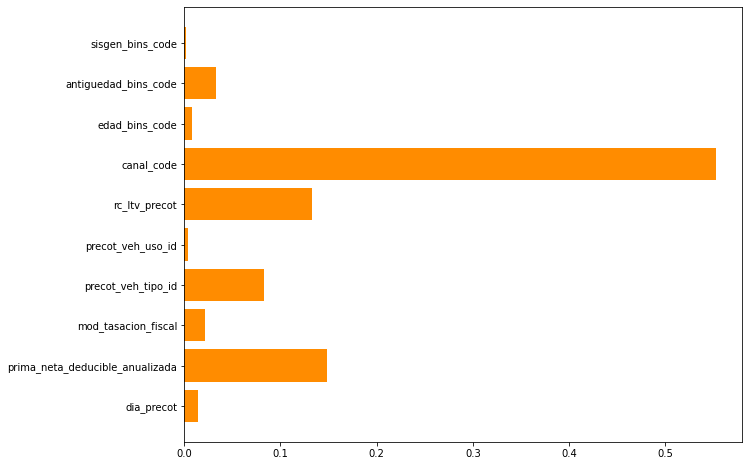

In [42]:
 # Features Importances
importances = dec_tree.feature_importances_
#importances = sorted(importances, reverse=True)

features = X_train.columns

# plot feature importance
plt.figure(figsize=(10,8))
plt.barh([x for x in features], importances, color = 'darkorange')
#plt.xticks(rotation=90)
plt.show();

# Metricas del Modelo

----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 

Precision: 0.740543 
Recall: 0.801608 
F1: 0.769867
AUC:  0.7603782203544674

 MATRIZ DE CONFUSION


Verdadero  Falso
Verdadero      39359  15371
Falso          10858  43872


 MÉTRICAS DEL MODELO


0             1  accuracy      macro avg   weighted avg
precision      0.783778      0.740543  0.760378       0.762161       0.762161
recall         0.719149      0.801608  0.760378       0.760378       0.760378
f1-score       0.750074      0.769867  0.760378       0.759970       0.759970
support    54730.000000  54730.000000  0.760378  109460.000000  109460.000000

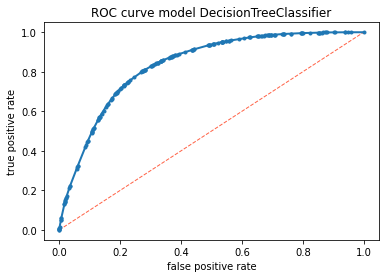


 TRADE-OFF PRECISION RECALL - TRAINING SET


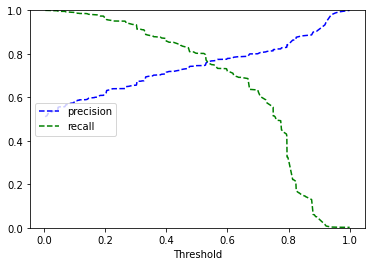


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 

Precision: 0.330357 
Recall: 0.795054 
F1: 0.466766
AUC:  0.7577094605840822

 MATRIZ DE CONFUSION


Verdadero  Falso
Verdadero      97376  37800
Falso           4807  18648


 MÉTRICAS DEL MODELO


0             1  accuracy      macro avg   weighted avg
precision       0.952957      0.330357  0.731408       0.641657       0.860900
recall          0.720365      0.795054  0.731408       0.757709       0.731408
f1-score        0.820496      0.466766  0.731408       0.643631       0.768193
support    135176.000000  23455.000000  0.731408  158631.000000  158631.000000

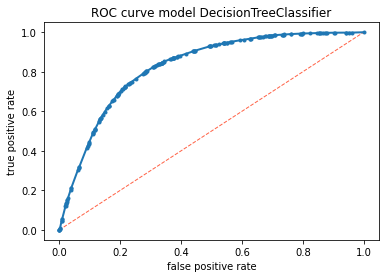


 TRADE-OFF PRECISION RECALL - TESTING SET


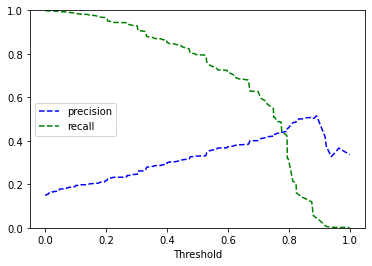

In [115]:
metrics_report(dec_tree, X_train, y_train, X_test, y_test)

# Tree Plot

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.792545 to fit



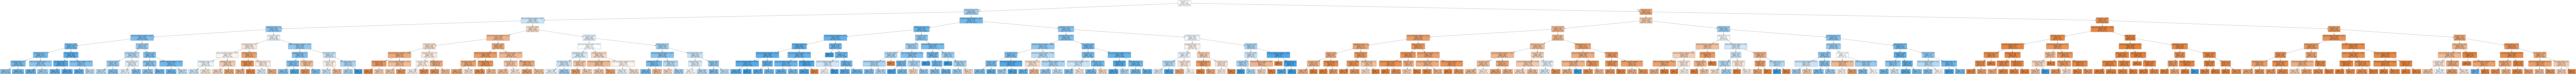

In [45]:
# Plot Decision Tree
features = X_train.columns
tree_graph_to_png(dec_tree, features, png_file_to_save='decision_tree.png')
Image('decision_tree.png')   

# Validación del Modelo

In [46]:
# Importando nuevos registros
files.upload()

Saving Predicciones_prob_conversion.xlsx to Predicciones_prob_conversion.xlsx


{'Predicciones_prob_conversion.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00`\x92z\xbe\x80\x01\x00\x00\x0c\x06\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [117]:
# file import to df
df_new = pd.read_excel('Predicciones_prob_conversion.xlsx', sheet_name='Dataset_predict').rename(columns={'canal_producto_code':'canal_code',
                                                                                                          'antigüedad' : 'antiguedad_veh'})

display(df_new.head())

dia_precot  prima_neta_deducible_anualizada  ...  antiguedad_veh  edad
0          25                            15.71  ...               0    34
1          25                            16.18  ...               0    34
2          25                            16.67  ...               0    34
3          25                            17.17  ...               0    34
4          25                            17.69  ...               0    34

[5 rows x 10 columns]

In [118]:
# Normalizando campos del df importado a la estructura modelada
df_norm(df_new)
display(df_new.head())

dia_precot  ...  sisgen_bins_code
0          25  ...                 0
1          25  ...                 0
2          25  ...                 0
3          25  ...                 0
4          25  ...                 0

[5 rows x 10 columns]

In [119]:
# Predicciones
y_new_predict = dec_tree.predict(df_new)
y_new_prob = dec_tree.predict_proba(df_new)

df_new = pd.concat([df_new, 
                    pd.Series(y_new_predict), 
                    pd.Series(y_new_prob[:,1])], 
                   axis=1).rename(columns={0 : 'Pred', 1 : 'Pred_Proba'})

In [142]:
df_new.to_excel("Predict_convert.xlsx",
                sheet_name='Predict')  

# Propuesta: Optimizacion Bayesiana de Hyperparametros

In [ ]:
# Optimizacion Bayesiana de Hiperparametros
param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
trials = Trials()

best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)

print ('best:')
print (best)

new best:
0.7502375296912114
{'criterion': 'entropy', 'max_depth': 14}
new best:
0.7502375296912114
{'criterion': 'entropy', 'max_depth': 16}
new best:
0.7582769961629819
{'criterion': 'gini', 'max_depth': 7}
new best:
0.7582769961629819
{'criterion': 'gini', 'max_depth': 5}
new best:
0.7598666179426274
{'criterion': 'entropy', 'max_depth': 11}
new best:
0.7598666179426274
{'criterion': 'entropy', 'max_depth': 5}
new best:
0.7598666179426274
{'criterion': 'entropy', 'max_depth': 12}
new best:
0.7598666179426274
{'criterion': 'entropy', 'max_depth': 6}
new best:
0.7598666179426274
{'criterion': 'gini', 'max_depth': 7}
new best:
0.7598666179426274
{'criterion': 'entropy', 'max_depth': 18}
100%|██████████| 10/10 [00:17<00:00,  1.72s/it, best loss: -0.7598666179426274]
best:
{'criterion': 1, 'max_depth': 10}


----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier
----------------------------------------------------------------------------
AUC:  0.8438931099363288

 MATRIZ DE CONFUSION


Verdadero  Falso
Verdadero      39648  15082
Falso           9777  44953


 MÉTRICAS DEL MODELO


0             1  accuracy      macro avg   weighted avg
precision      0.802185      0.748780  0.772894       0.775483       0.775483
recall         0.724429      0.821359  0.772894       0.772894       0.772894
f1-score       0.761327      0.783392  0.772894       0.772360       0.772360
support    54730.000000  54730.000000  0.772894  109460.000000  109460.000000

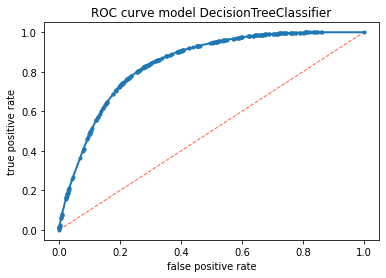

In [ ]:
# Se entrena el Arbol con los parametros sugeridos por HyperOpt
tree_model = DecisionTreeClassifier(criterion= 'entropy', 
                                    max_depth=10,
                                    random_state=1).fit(X = X_train, y = y_train)

#Desempeño del Nuevo Modelo (AUC)
tree_auc2, tree_metrics2 = metrics_model(tree_model, X_train, y_train, X_test)